In [275]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
# from catboost import CatBoostClassifier
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import math

In [72]:
warnings.filterwarnings("ignore")

In [240]:
data = pd.read_csv("train-2.csv")

In [241]:
answer = list(set(data[data.TargetClass == 0].SpType.unique()) & set(data[data.TargetClass == 1].SpType.unique()))

In [242]:
answer

['K1III-IV',
 'G6IV/V',
 'B5Ia',
 'K0IVw...',
 'B9IIp...',
 'B0.5IVn',
 'G6V',
 'K3III',
 'G5V',
 'B2.5V',
 'F8III/IV',
 'A6:III:+...',
 'A3III + K1:',
 'G6/8wF8IV/V',
 'F0IIw...',
 'F6/F7V',
 'B3III',
 'B6III',
 'A2/A3III',
 'F3V:+...',
 'F0III:',
 'K1IV/V',
 'G9IV',
 'K0V',
 'G8V',
 'B9:Vn...',
 'K3V',
 'B4II/III',
 'G8IVp',
 'F9III',
 'A2II/III',
 'K0IV/VCNIII',
 'K1IVCN...',
 'B7Ib',
 'G6/G8III/IV',
 'O9.5Ia SB:',
 'G8/K0IV/V',
 'F0/F2IVm...',
 'A3Vs',
 'B3Vn...',
 'B1.5III-IVn',
 'B9V+...',
 'G4V:p',
 'K1/K2V',
 'B6II/III',
 'K1IV...',
 'K7V',
 'K0:III+...',
 'F3IVp...',
 'G8IV',
 'K3IV/V',
 'G3/G5Vw',
 'K2/K3V',
 'K1IV',
 'B8Ia-Iab',
 'B0IVpe',
 'K0IV:',
 'B2V+...',
 'B8II',
 'K1/2III: +F',
 'B4II',
 'A3II/IIIm..',
 'K3III+A0IV/V',
 'A4V comp SB',
 'A4/A5III:',
 'A2V+...',
 'A8III',
 'G9III-IV',
 'K0/K1IVwp..',
 'B7Iab...',
 'F4IIIvar',
 'G9V',
 'B7II',
 'A(V) + G5III',
 'G5III-IV',
 'B7Ib/II',
 'K0VCN...',
 'A6III',
 'G3V',
 'G8IV...',
 'G3IV/V',
 'B2IV-Ve',
 'B0Ib/II',
 'B2III-

In [243]:
data = data[~data.SpType.isin(answer)]

In [244]:
color_index = lambda x: 4600 * ((1 / (0.92 * x + 1.7)) + (1 / (0.92 * x + 0.62)))
transform_type = lambda x: 99999 if "V" in x or "VI" in x or "VII" in x else -99999
round_ = lambda x: round(x, 1)

In [245]:
data["temp"] = data["B-V"].apply(color_index)

In [246]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.334196,2.198947,0.593309,1.153210,G2Ib,13.043324,0,4402.632871
2,7.873019,11.750465,0.616568,0.589166,F5V,17.736492,1,6010.288989
3,8.110014,2.143815,0.848508,1.322107,K2III,15.592469,0,4082.305608
4,8.025193,4.165622,0.899296,1.141646,K5III,16.379680,0,4426.508743
5,2.899130,11.110086,0.701719,1.095357,M0III,14.370388,0,4524.866088


In [247]:
data.SpType = data.SpType.apply(transform_type)

In [248]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.334196,2.198947,0.593309,1.153210,-99999,13.043324,0,4402.632871
2,7.873019,11.750465,0.616568,0.589166,99999,17.736492,1,6010.288989
3,8.110014,2.143815,0.848508,1.322107,-99999,15.592469,0,4082.305608
4,8.025193,4.165622,0.899296,1.141646,-99999,16.379680,0,4426.508743
5,2.899130,11.110086,0.701719,1.095357,-99999,14.370388,0,4524.866088


In [249]:
data = data[data.Plx + data.e_Plx > 0]

In [250]:
# plt.boxplot(data.Vmag)

In [251]:
# data = data[(data.Vmag > 4) & (data.Vmag < 11)]

In [252]:
# plt.boxplot(data["B-V"])

In [253]:
# data = data[data["B-V"] < 23]

In [254]:
# plt.boxplot(data.Amag)

In [255]:
# data = data[(data.Amag < 22) & (data.Amag > 10)]

In [256]:
data.Amag = data.Amag.apply(round_)
data.Vmag = data.Vmag.apply(round_)
data.Plx = data.Plx.apply(round_)
data.e_Plx = data.e_Plx.apply(round_)
data["B-V"] = data["B-V"].apply(round_)
data.temp = data.temp.apply(round_)
# model["BVtype"] = round(model["B-V"] * model.SpType)

In [257]:
# data = data.drop(["Vmag", "Plx", "e_Plx"], axis=1)

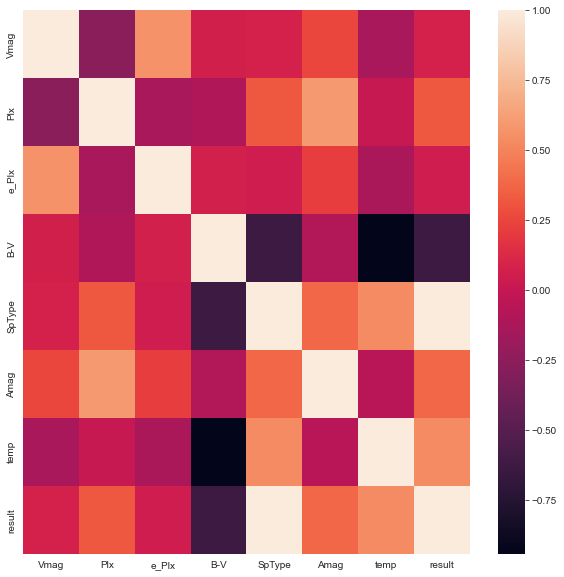

In [258]:
y = data['TargetClass']
X = data.drop(columns=['TargetClass'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

fig = plt.figure(figsize=(10, 10))
X_test2 = X_test.copy()
X_test2["result"] = y_test
data_ploting = X_test2.corr(method='pearson')
sns.heatmap(data_ploting, linecolor='black')
plt.show()

In [259]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.3,2.2,0.6,1.2,-99999,13.0,0,4402.6
2,7.9,11.8,0.6,0.6,99999,17.7,1,6010.3
3,8.1,2.1,0.8,1.3,-99999,15.6,0,4082.3
4,8.0,4.2,0.9,1.1,-99999,16.4,0,4426.5
5,2.9,11.1,0.7,1.1,-99999,14.4,0,4524.9


In [277]:

%%time
params = {
    'min_child_weight': [1, 5, 10, 15],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': range(1, 30)
}
#rfc = RandomForestClassifier(random_state = 42, n_jobs = -1)
rfc = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)
folds = 5
param_comb = 30

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = GridSearchCV(rfc, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3)


random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5220 candidates, totalling 26100 fits



KeyboardInterrupt



In [270]:
%%time
xgb = XGBClassifier(subsample=0.8,
                     min_child_weight=1,
                     max_depth=14,
                     gamma=1,
                     colsample_bytree=0.8)
xgb.fit(X_train, y_train)

CPU times: total: 2.03 s
Wall time: 286 ms


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [271]:
random_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 14,
 'gamma': 1,
 'colsample_bytree': 0.8}

In [272]:
pred = xgb.predict(X_test)

In [273]:
roc_auc_score(y_test, pred)

0.9992493823061369

In [222]:
data_ = pd.read_csv("predict.csv")

In [223]:
data_test = data_.copy()

In [224]:
data_test["temp"] = data_test["B-V"].apply(color_index)

In [225]:
list(data.columns) == list(data_test.columns)

False

In [226]:
data.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'TargetClass', 'temp'], dtype='object')

In [227]:
data_test.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'temp'], dtype='object')

In [228]:
data_test.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,temp
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122,11536.343340
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976,3972.332732
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103,4862.277063
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838,4735.981168
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981,6419.225528


In [229]:
data_test.SpType = data_test.SpType.apply(transform_type)

In [230]:
pred = xgb.predict(data_test.values)

In [231]:
data_["TargetClass"] = pred

In [232]:
data_

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122,1
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976,0
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103,0
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838,0
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981,0
...,...,...,...,...,...,...,...
7906,8.255272,2.858885,0.822289,1.349195,M3III,16.438014,0
7907,6.255358,3.034436,0.449386,0.966053,K0III,13.898403,0
7908,8.643598,10.932145,0.947897,0.504383,G0V,18.980729,1
7909,9.400810,6.279361,1.332124,0.351073,F2V,16.872491,1


In [233]:
data_.to_csv("answer.csv")